  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], G Loss: -0.1086, D Loss: -0.6055, IPM ratio: 0.4116, Lambda: -0.0003


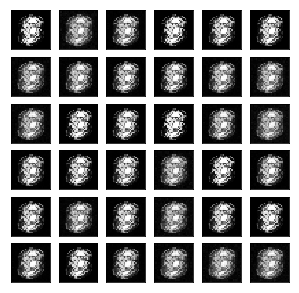

  4%|▍         | 1/25 [00:19<07:41, 19.25s/it]

Epoch[2/25], G Loss: -0.1139, D Loss: -0.5968, IPM ratio: 0.6846, Lambda: -0.0007


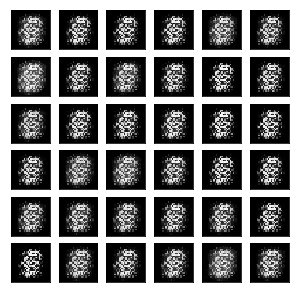

  8%|▊         | 2/25 [00:38<07:19, 19.13s/it]

Epoch[3/25], G Loss: -0.1090, D Loss: -0.7148, IPM ratio: 0.6181, Lambda: -0.0010


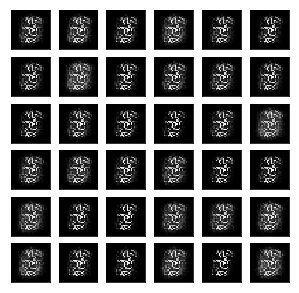

 12%|█▏        | 3/25 [00:57<07:01, 19.14s/it]

Epoch[4/25], G Loss: -0.2026, D Loss: -0.5901, IPM ratio: 0.2350, Lambda: -0.0013


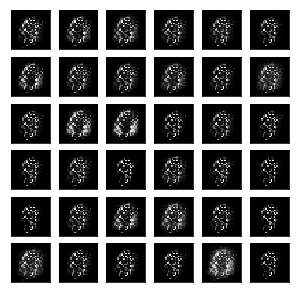

 16%|█▌        | 4/25 [01:17<06:45, 19.31s/it]

Epoch[5/25], G Loss: -0.2620, D Loss: -0.5788, IPM ratio: 0.3838, Lambda: -0.0016


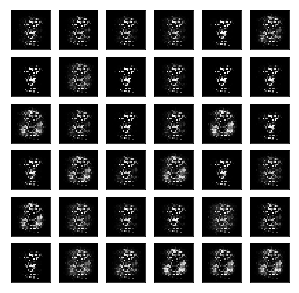

 20%|██        | 5/25 [01:35<06:21, 19.08s/it]

Epoch[6/25], G Loss: -0.1626, D Loss: -0.6448, IPM ratio: 0.5404, Lambda: -0.0019


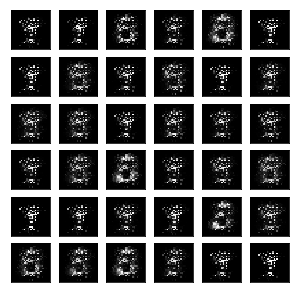

 24%|██▍       | 6/25 [01:59<06:18, 19.93s/it]

Epoch[7/25], G Loss: -0.0977, D Loss: -0.7642, IPM ratio: 0.4623, Lambda: -0.0022


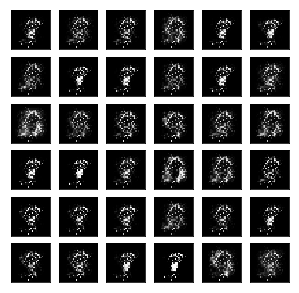

 28%|██▊       | 7/25 [02:23<06:08, 20.48s/it]

Epoch[8/25], G Loss: -0.1284, D Loss: -0.6814, IPM ratio: 0.5612, Lambda: -0.0025


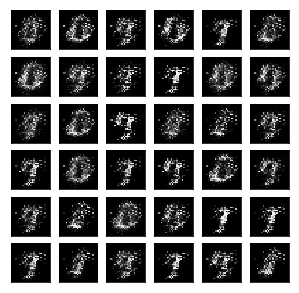

 32%|███▏      | 8/25 [02:42<05:44, 20.26s/it]

Epoch[9/25], G Loss: -0.1492, D Loss: -0.5897, IPM ratio: 0.6012, Lambda: -0.0028


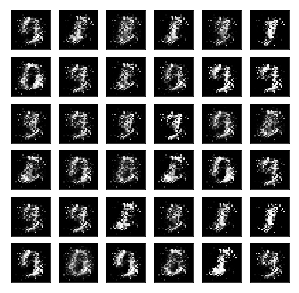

 36%|███▌      | 9/25 [02:59<05:19, 19.96s/it]

Epoch[10/25], G Loss: -0.1022, D Loss: -0.6733, IPM ratio: 0.7065, Lambda: -0.0031


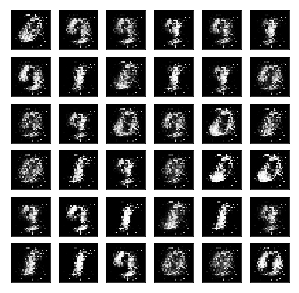

 40%|████      | 10/25 [03:18<04:57, 19.85s/it]

Epoch[11/25], G Loss: -0.1576, D Loss: -0.5726, IPM ratio: 0.3322, Lambda: -0.0034


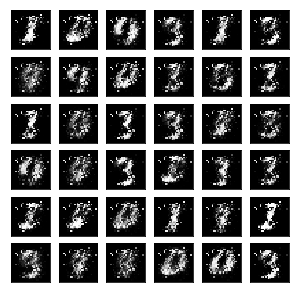

 44%|████▍     | 11/25 [03:38<04:38, 19.90s/it]

Epoch[12/25], G Loss: -0.1891, D Loss: -0.5077, IPM ratio: 0.4973, Lambda: -0.0037


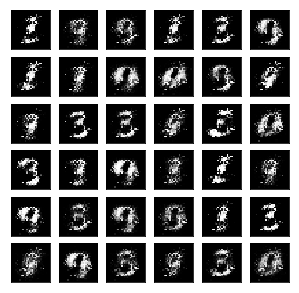

 48%|████▊     | 12/25 [04:00<04:20, 20.07s/it]

Epoch[13/25], G Loss: -0.1023, D Loss: -0.6171, IPM ratio: 0.7891, Lambda: -0.0041


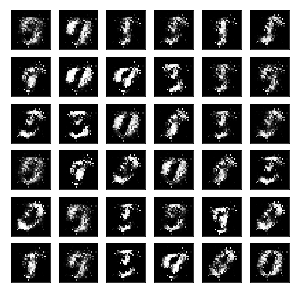

 52%|█████▏    | 13/25 [04:21<04:01, 20.09s/it]

Epoch[14/25], G Loss: -0.0782, D Loss: -0.7258, IPM ratio: 0.6697, Lambda: -0.0044


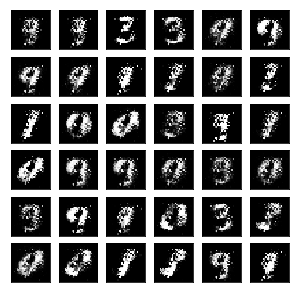

 56%|█████▌    | 14/25 [04:39<03:39, 19.95s/it]

Epoch[15/25], G Loss: -0.0666, D Loss: -0.6991, IPM ratio: 0.7995, Lambda: -0.0047


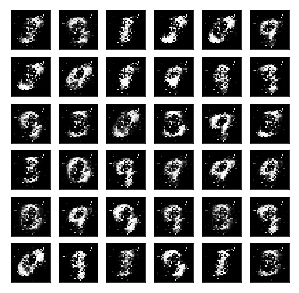

 60%|██████    | 15/25 [05:01<03:21, 20.12s/it]

Epoch[16/25], G Loss: -0.0554, D Loss: -0.7896, IPM ratio: 0.6227, Lambda: -0.0050


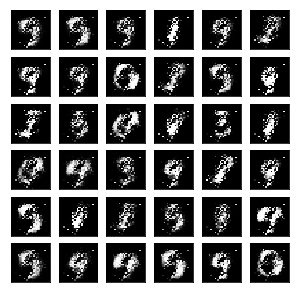

 64%|██████▍   | 16/25 [05:23<03:02, 20.24s/it]

Epoch[17/25], G Loss: -0.0989, D Loss: -0.6865, IPM ratio: 0.7128, Lambda: -0.0053


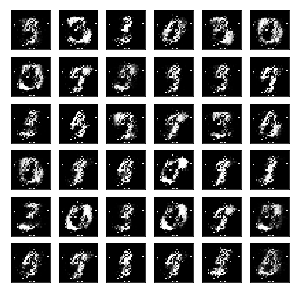

 68%|██████▊   | 17/25 [05:47<02:43, 20.46s/it]

Epoch[18/25], G Loss: -0.0765, D Loss: -0.7445, IPM ratio: 0.7419, Lambda: -0.0056


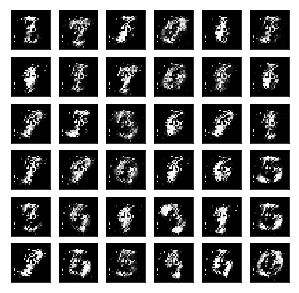

 72%|███████▏  | 18/25 [06:11<02:24, 20.64s/it]

Epoch[19/25], G Loss: -0.0948, D Loss: -0.6961, IPM ratio: 0.6997, Lambda: -0.0059


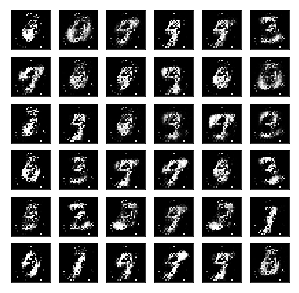

 76%|███████▌  | 19/25 [06:34<02:04, 20.75s/it]

Epoch[20/25], G Loss: -0.1248, D Loss: -0.6642, IPM ratio: 0.4011, Lambda: -0.0062


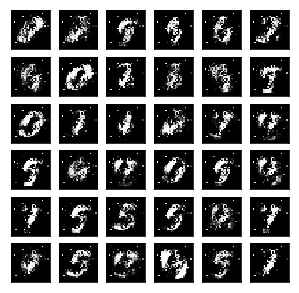

 80%|████████  | 20/25 [06:52<01:43, 20.61s/it]

Epoch[21/25], G Loss: -0.0897, D Loss: -0.7437, IPM ratio: 0.6628, Lambda: -0.0065


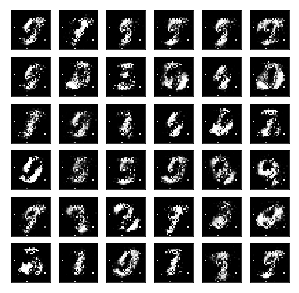

 84%|████████▍ | 21/25 [07:11<01:22, 20.53s/it]

Epoch[22/25], G Loss: -0.1171, D Loss: -0.6574, IPM ratio: 0.4715, Lambda: -0.0068


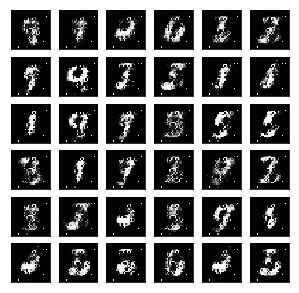

 88%|████████▊ | 22/25 [07:28<01:01, 20.38s/it]

Epoch[23/25], G Loss: -0.0934, D Loss: -0.7246, IPM ratio: 0.4678, Lambda: -0.0071


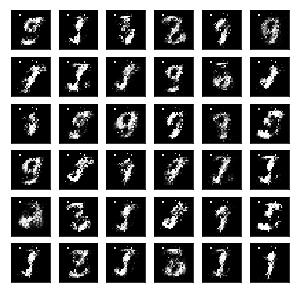

 92%|█████████▏| 23/25 [07:45<00:40, 20.22s/it]

Epoch[24/25], G Loss: -0.0912, D Loss: -0.6973, IPM ratio: 0.8085, Lambda: -0.0074


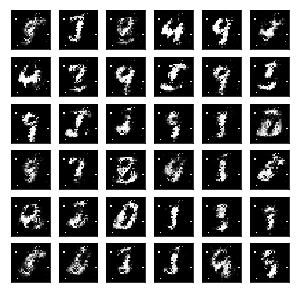

 96%|█████████▌| 24/25 [08:04<00:20, 20.21s/it]

Epoch[25/25], G Loss: -0.0736, D Loss: -0.7758, IPM ratio: 0.5327, Lambda: -0.0077


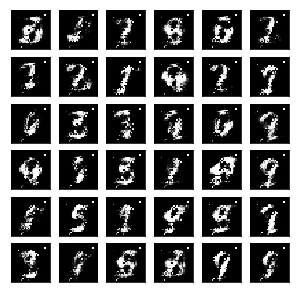

100%|██████████| 25/25 [08:23<00:00, 20.12s/it]


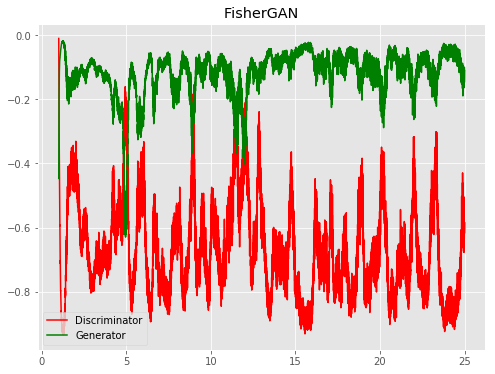

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.fisher_gan import *

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = FisherGAN(image_size=784,
                  hidden_dim=256,
                  z_dim=128)

# Init trainer
trainer = FisherGANTrainer(model=model,
                           train_iter=train_iter,
                           val_iter=val_iter,
                           test_iter=test_iter,
                           viz=True)

# Train
trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)

# Show loss
trainer.viz_loss()